# Transfer Learning with TensorFlow Part 2: Fine-tuning

**fine-tuning transfer learning** - pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data

In feature extraction transfer learning, only the top 1-3 layers of pre-trained model can be trained with our data. However, in fine-tuning transfer learning, we can train, not only the 1-3 top layers, but many more layers

Going to cover:

- Introduce fine-tuning transfer learning
- Using the Keras Functional API (different way to build models in Keras)
- Using smaller dataset to experiment faster (1-10% of training samples)
- Data augmentation (make training dataset more diverse without adding more data)
- Running series of modeling eperiements on the Food Vision data
  - Model 0: a transfer learning model using Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce ModelCheckpoint callback to save intermediate training results
- Compare model experiments using TensorBoard

Import Helper Functions 

In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-02-12 19:40:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-12 19:40:58 (42.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Working with less data

In [2]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2023-02-12 19:41:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   101MB/s    in 1.6s    

2023-02-12 19:41:06 (101 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# View file structure
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

Define training and test filepaths

In [4]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

This time we'll be using **Keras's 'image_data_from_directory'** rather than ImageDataGenerator's 'flow_from_directory'

One of the main benefits of using tf.keras.prepreprocessing.image_dataset_from_directory() rather than ImageDataGenerator is that it creates a tf.data.Dataset object rather than a generator. 

The main advantage of this is the tf.data.Dataset API is much more efficient (faster) than the ImageDataGenerator API which is great for larger datasets

In [5]:
# Create data inputs
import tensorflow as tf

IMG_SIZE = (224, 224) 
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical', 
                                                                            batch_size=32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Main Parameters:

- directory = filepath of the directory where images are loaded from
- image_size = the target size of images we're loading in
- batch_size = batch size of images we're going to load in (default 32)

In [6]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the output above:
- (None, 224, 224, 3) refers to the tensor shape of our images where None is the batch size, 224 is the height (and width) and 3 is the color channels (red, green, blue).
- (None, 10) refers to the tensor shape of the labels where None is the batch size and 10 is the number of possible labels (the 10 different food classes).

Another benefit of tf.data.Dataset API is the methods...

In [7]:
# View class names using class_names() method
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [65]:
# An example batch of data using take() method
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[4.33571434e+01 3.73571434e+01 2.33571434e+01]
   [4.36887779e+01 3.76887779e+01 2.36887760e+01]
   [4.55714302e+01 3.93571434e+01 2.77857151e+01]
   ...
   [2.82908306e+01 3.22908287e+01 3.48623009e+01]
   [2.95459003e+01 3.45459023e+01 3.75459023e+01]
   [2.48570385e+01 2.98570385e+01 3.38570366e+01]]

  [[4.50459175e+01 3.90459175e+01 2.50459175e+01]
   [4.80000038e+01 4.20000038e+01 3.00000000e+01]
   [4.80714302e+01 4.18571434e+01 3.02857151e+01]
   ...
   [1.93570995e+01 2.33570995e+01 2.43570995e+01]
   [1.29336491e+01 1.89285450e+01 1.89285450e+01]
   [6.76524162e+00 1.16683006e+01 1.44540148e+01]]

  [[4.56428566e+01 3.96428566e+01 2.72142849e+01]
   [4.89285736e+01 4.29285736e+01 3.09285717e+01]
   [4.86632652e+01 4.23367348e+01 3.18316326e+01]
   ...
   [5.87754154e+00 9.87754154e+00 9.64281368e+00]
   [4.18368053e+00 1.01683712e+01 8.59694290e+00]
   [5.78063869e+00 1.12755289e+01 9.70410061e+00]]

  ...

  [[1.39147964e+02 1.32147964e+02 1.26147957e+02]
   [1

# Model 0: Building a transfer learning model using the Keras Functional API¶


Steps:
1. Pass the inputs to the base model.
2. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using tf.keras.layers.GlobalAveragePooling2D() or tf.keras.layers.GlobalMaxPooling2D() though the former is more common in practice.
3. Create an output activation layer using tf.keras.layers.Dense() with the appropriate activation function and number of neurons.
4. Combine the inputs and outputs layer into a model using tf.keras.Model().
5. Compile the model using the appropriate loss function and choose of optimizer.
6. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

In [9]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # Set to false since we're going to create our own top (output layers for the model)

# 2. Freeze the base model (so pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using ResNet50V2 model, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (Using tf.keras.applications, EfficientNet inputs don't need to be normalized)
x = base_model(inputs)

# Check data shape after passing to base_model
print(f"Shape after base_model:  {x.shape}")

# 6. Average pool the ouputs of the base model (aggregate all the most important information)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_feature_extract')])

16705208/16705208 [==============================] - 0s 0us/step


Shape after base_model:  (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230212-194132
Epoch 1/5
24/24 [==============================] - 21s 241ms/step - loss: 1.8654 - accuracy: 0.4467 - val_loss: 1.3089 - val_accuracy: 0.7253
Epoch 2/5
24/24 [==============================] - 4s 150ms/step - loss: 1.0836 - accuracy: 0.7747 - val_loss: 0.8951 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.7894 - accuracy: 0.8240 - val_loss: 0.6910 - val_accuracy: 0.8306
Epoch 4/5
24/24 [==============================] - 5s 181ms/step - loss: 0.6409 - accuracy: 0.8640 - val_loss: 0.6251 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 4s 148ms/step - loss: 0.5452 - accuracy: 0.8787 - val_loss: 0.5616 - val_accuracy: 0.8536


Model performs fairly well with training set (~ 87% accuracy) 

Summary of building this model:
- Transfer learning used: Feature Extraction
- Passed custom data to an already pre-trained model (EfficientNetB0)
- Put our own output layer on top to make sure output were tailored to our number of classes
- Used Keras Functional API to build model rather than the Sequential API 


In [10]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

Lots of layers that we didn't have to code ourselves

Overall summary of the model

In [11]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Model has 5 layers with the EfficientNetB0 layer having 236 layers

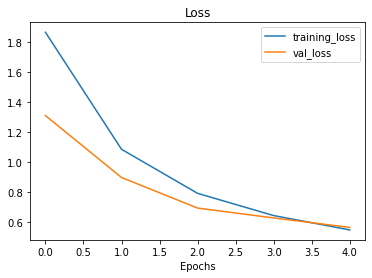

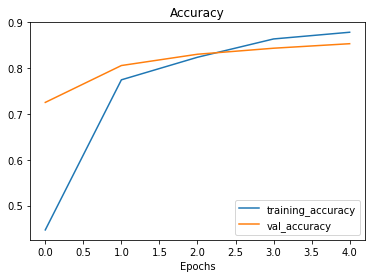

In [12]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

# Getting a feature vector from a trained model

The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

In [13]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


Can replication this by using the tf.reduce_mean() operation

In [14]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>


Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension feature vector.

# Running a series of transfer learning experiments

1. model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

- All experiments will be done using the EfficientNetB0 model within the tf.keras.applications module.
- Using create_tensorboard_callback() function to log all of the experimental
- Construct each model using the Keras Functional API
- Instead of implementing data augmentation in the ImageDataGenerator class, build it right into the model using the tf.keras.layers.experimental.preprocessing module




---

Prepare the 1 percent data set


In [15]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-02-12 19:42:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   162MB/s    in 0.8s    

2023-02-12 19:42:12 (162 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [16]:
# Walk through the 1 percent data directory
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There a

Load images in as tf.data.Dataset objects using the image_dataset_from_directory() method

In [17]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Adding data augmentation (build it right into the model)

How?

- Using the tf.keras.layers.experimental.preprocessing module and creating dedicated data augmentation layer

Data Augmentation transformations
- RandomFlip - flips image on horizontal or vertical axis.
- RandomRotation - randomly rotates image by a specified amount.
- RandomZoom - randomly zooms into an image by specified amount.
- RandomHeight - randomly shifts image height by a specified amount.
- RandomWidth - randomly shifts image width by a specified amount.
- Rescaling - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the tf.keras.applications implementation of EfficientNetB0, it's not required.

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation layer
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # Need this line if using ResNet50V2, but since we're using EfficientNetB0, normalization is built in
], name = 'data_augmentation')

Visualizing our data augmentation

(-0.5, 581.5, 554.5, -0.5)

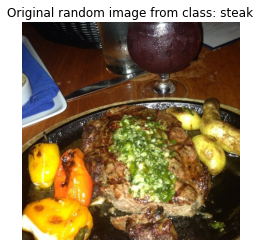

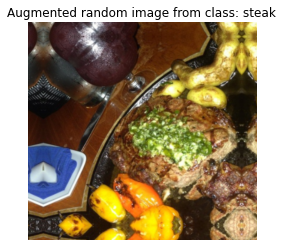

In [19]:
# Viewing a random image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names) # Choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # Create target directory
random_image = random.choice(os.listdir(target_dir)) # Choose a random image from the target directory
random_image_path = target_dir + "/" + random_image # Create image path of the chosen image
img = mpimg.imread(random_image_path) # Read in the chosen image

# Original Image
plt.imshow(img) # Plot the chosen image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False) # Turn off axis

# Augmented Image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # Data augmentation requires shape (None, Height, Width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # Requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

# Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [20]:
# Setup input shape and base model, freeze base mode layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback('transfer_learning', '1_percent_data_aug')]) # Track model training logs

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230212-194222
Epoch 1/5


3/3 [==============================] - 18s 4s/step - loss: 2.4230 - accuracy: 0.0714 - val_loss: 2.3240 - val_accuracy: 0.1053
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1803 - accuracy: 0.2000 - val_loss: 2.1980 - val_accuracy: 0.1727
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0625 - accuracy: 0.2714 - val_loss: 2.0710 - val_accuracy: 0.2681
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8377 - accuracy: 0.4000 - val_loss: 1.9926 - val_accuracy: 0.3339
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6753 - accuracy: 0.6143 - val_loss: 1.8542 - val_accuracy: 0.4375


Looks like model was able to get around ~ 45% accuracy on validation set. Not too bad

In [21]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

Notice how our model got data augmentation built right into the model.

Do note: data augmentation only runs during training

In [22]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 91ms/step - loss: 1.8815 - accuracy: 0.4160


[1.881511926651001, 0.41600000858306885]

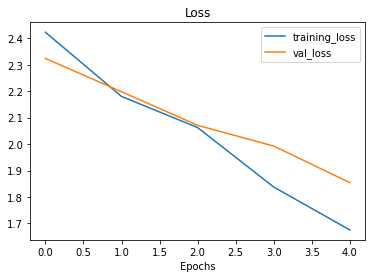

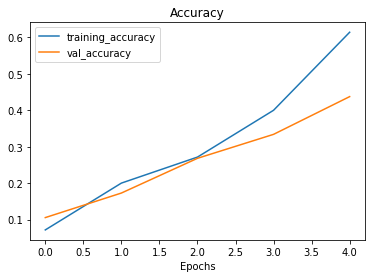

In [23]:
# Check model's lose curve with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

# Model 2: Feature extraction transfer learning with 10% of data and data augmentation

Go through exact same steps as above but use 10% of training data rather than 1%

In [24]:
# Get 10% of the data of the 10 classes (uncomment if don't have "10_food_classes_10_percent.zip" already)

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")


In [25]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Create dataloaders

In [26]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Create model with data augmentation built int

In [27]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # don't need b/c using EfficientNetB0
], name = 'data_augmentation')

# Set up the input shape to model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name='input_layer') # Input layer
x = data_augmentation(inputs) # Augment the training images
x = base_model(x, training = False) # Pass augmented images to base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

## Creating a ModelCheckpoint callback

The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.
- Weights vs Entire Model
 - If you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Useful if training is going to take a long time or want to make backups as model trains

Can reload from checkpoint and continue training from there

In [28]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

Fit the model

In [29]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230212-194311
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 2.0354 - accuracy: 0.3400
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 27s 721ms/step - loss: 2.0354 - accuracy: 0.3400 - val_loss: 1.4722 - val_accuracy: 0.6497
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3313 - accuracy: 0.7027
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 572ms/step - loss: 1.3313 - accuracy: 0.7027 - val_loss: 1.0190 - val_accuracy: 0.7977
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0100 - accuracy: 0.7800
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 588ms/step - loss: 1.0100 - accuracy: 0.7800 - val_loss: 0.8100 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8385 - accuracy: 0.8013
Epoch

In [30]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 85ms/step - loss: 0.6282 - accuracy: 0.8476


[0.6282360553741455, 0.847599983215332]

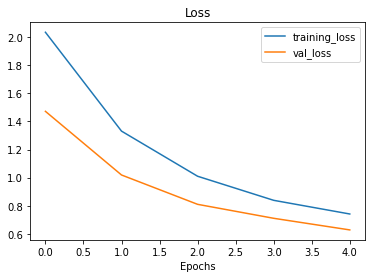

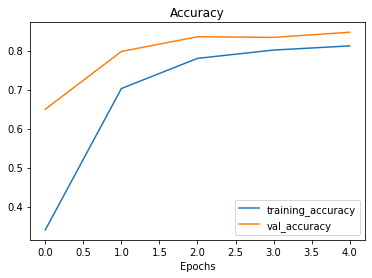

In [31]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

To load saved model weights from check point, use the the load_weights() method, passing it the path where saved weights are stored.

In [32]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6282 - accuracy: 0.8476


In [33]:
# If the results from our model and the saved loaded weights model are the same
results_10_percent_data_aug == loaded_weights_model_results

False

We get false because of how how computers store number with degree of percision. However, they should be VERY close:

In [34]:
import numpy as np

# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [35]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-2.98023224e-07  0.00000000e+00]


# Model 3: Fine-tuning an existing model on 10% of the data

In [36]:
# Layers in loaded model
model_2.layers

In [37]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [38]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [39]:
# How many layers are trainable in our base model?
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


In [40]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

In [41]:
# Unfreeze all the layers
base_model.trainable = True

# Refreeze all layers except for the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [42]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [43]:
# Checking trainable variables
print(len(model_2.trainable_variables))

12


The model has a total of 10 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

In [44]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5 # inital_epochs = 5 defined from the last model

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230212-194507
Epoch 5/10


24/24 [==============================] - 28s 611ms/step - loss: 0.6407 - accuracy: 0.8200 - val_loss: 0.5277 - val_accuracy: 0.8438
Epoch 6/10
24/24 [==============================] - 14s 546ms/step - loss: 0.5166 - accuracy: 0.8427 - val_loss: 0.4979 - val_accuracy: 0.8355
Epoch 7/10
24/24 [==============================] - 12s 473ms/step - loss: 0.4475 - accuracy: 0.8667 - val_loss: 0.4328 - val_accuracy: 0.8684
Epoch 8/10
24/24 [==============================] - 12s 492ms/step - loss: 0.4017 - accuracy: 0.8827 - val_loss: 0.4181 - val_accuracy: 0.8783
Epoch 9/10
24/24 [==============================] - 12s 477ms/step - loss: 0.3720 - accuracy: 0.8907 - val_loss: 0.4265 - val_accuracy: 0.8668
Epoch 10/10
24/24 [==============================] - 12s 499ms/step - loss: 0.3100 - accuracy: 0.9080 - val_loss: 0.4535 - val_accuracy: 0.8487


In [45]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 0.4225 - accuracy: 0.8628


In [46]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3400000035762787, 0.7026666402816772, 0.7799999713897705, 0.8013333082199097, 0.8119999766349792, 0.8199999928474426, 0.8426666855812073, 0.8666666746139526, 0.8826666474342346, 0.890666663646698, 0.9079999923706055]


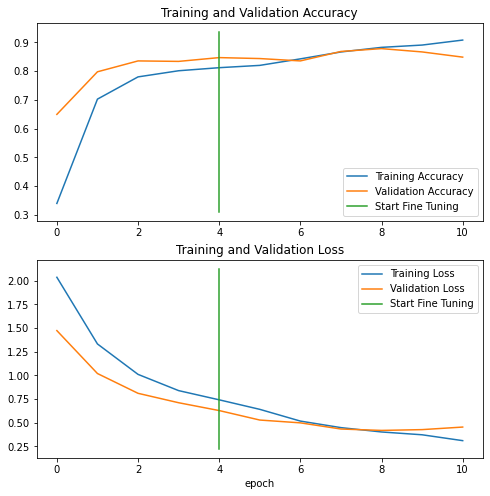

In [47]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

The curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

# Model 4: Fine-tuning an existing model with all of the data

In [48]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-02-12 19:46:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   130MB/s    in 3.7s    

2023-02-12 19:46:51 (135 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [49]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.

In [50]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

In [51]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.4225 - accuracy: 0.8628


[0.4225176274776459, 0.8628000020980835]

In [52]:
results_fine_tune_10_percent

[0.42251771688461304, 0.8628000020980835]

Revert the model back to the saved weights.

In [66]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

ValueError: ignored


And the results should be the same as results_10_percent_data_aug

In [55]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 0.6282 - accuracy: 0.8476


[0.6282361745834351, 0.847599983215332]

In [56]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug

[0.6282360553741455, 0.847599983215332]


Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

In [57]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [58]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

We just reloaded the weights to our model and what do we need to do every time we make a change to our models? RECOMPILE

In [59]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [60]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230212-195000
Epoch 5/10


235/235 [==============================] - 106s 398ms/step - loss: 0.6607 - accuracy: 0.7903 - val_loss: 0.4250 - val_accuracy: 0.8487
Epoch 6/10
235/235 [==============================] - 88s 371ms/step - loss: 0.5224 - accuracy: 0.8319 - val_loss: 0.3914 - val_accuracy: 0.8717
Epoch 7/10
235/235 [==============================] - 84s 354ms/step - loss: 0.4613 - accuracy: 0.8500 - val_loss: 0.3879 - val_accuracy: 0.8750
Epoch 8/10
235/235 [==============================] - 82s 347ms/step - loss: 0.4211 - accuracy: 0.8628 - val_loss: 0.3615 - val_accuracy: 0.8849
Epoch 9/10
235/235 [==============================] - 78s 332ms/step - loss: 0.3868 - accuracy: 0.8745 - val_loss: 0.3331 - val_accuracy: 0.8914
Epoch 10/10
235/235 [==============================] - 79s 334ms/step - loss: 0.3616 - accuracy: 0.8856 - val_loss: 0.3509 - val_accuracy: 0.8816


In [61]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 73ms/step - loss: 0.2834 - accuracy: 0.9068


[0.2834157347679138, 0.9067999720573425]

5
11
[0.3400000035762787, 0.7026666402816772, 0.7799999713897705, 0.8013333082199097, 0.8119999766349792, 0.7902666926383972, 0.8318666815757751, 0.8500000238418579, 0.8628000020980835, 0.8745333552360535, 0.8855999708175659]


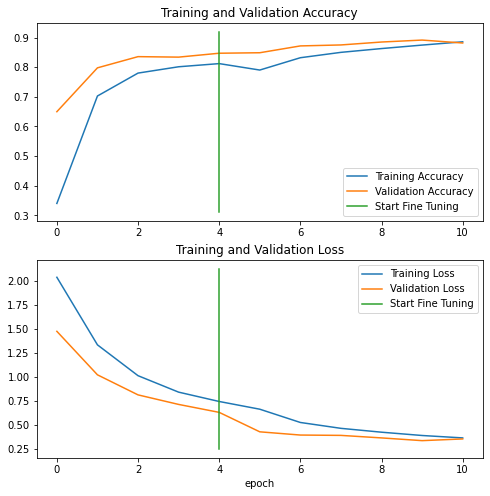

In [62]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)


Looks like that extra data helped! Those curves are looking great. And if we trained for longer, they might even keep improving.

# Viewing our experiment data on TensorBoard

In [63]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2023-02-12 19:59:48.542550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-12 19:59:48.542659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-12 19:59:48.542678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBo

In [64]:
# View previous experiments
!tensorboard dev list

2023-02-12 20:15:27.281659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-12 20:15:27.281788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-12 20:15:27.281809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/spQCyILlR9qDP5D5LNg3LQ/
	Name                 Transfer learning experiments
	Description          A series of different transfer lea